### Introduction

In this project, I am trying to perform a voice conversion, that is to say, I am trying to change the identity of the speaker without changing the content and the intonation of the sentences as described (in more detail) here:

https://arxiv.org/abs/1610.04019

I need two main steps: 

- The first is the analysis of the voice to extract important features. 
- The second is the creation of a neural network ( a variational autoencoder) to perform the voice conversion using these features (changing the voice by changing the identity of the speaker). 

In this tutorial, I will only focus on the second part that uses the variational auto-encoder. 

To simplify the problem, I will not work on the conversion of the speaker's identity directly but on the conversion of the style of hand-written digits. 

In fact, we have two latent factors in our variational auto-encoder: identity and variation.
For a hand-written digit, the identity is the nominal number and the variation is the hand-writing style. For a speech frame, the identity could be the speaking source and the variation could be the phonetic content.

So working on hand-written digits can be considered as a first step after which I can adapt my work to do the same thing with voice 


This project 
https://arxiv.org/abs/1610.04019 

# Variational autoencoders 
Acknowledgment: Some pieces of code are taken from this tutorial 
https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/ (but the purpose of this tutorial is different)


The global architecture to perform the hand-written digits style conversion is the following:

- Xn is the image of the hand-written digit
- Yn in a one-hot vector which gives the class of the digit (from 0 to 9)
- Zn is the latent vector

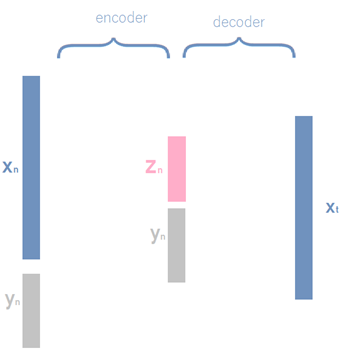

##### Keras
It is an open-source neural-network library written in Python. It is capable of running on top of TensorFlow, Microsoft Cognitive Toolkit, R, Theano, or PlaidML.
Designed to enable fast experimentation with deep neural networks, it focuses on being user-friendly, modular and extensible.

##### libraries


In [12]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
import keras as Keras 

from keras.layers import (Input, InputLayer, Dense, Lambda, Layer, Add, Multiply)
from keras.models import Model, Sequential
from keras.datasets import mnist

import pandas as pd

from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

import tensorflow as tf

##### Notebook configuration

In [13]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)
#These options determine the way floating point numbers, arrays and other NumPy objects are displayed.

##### Dataset (MNIST)

In [14]:
#Mnist dataset
# x are the pictures of the digits and y are the labels of digits 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.
#Dimensions 
img_rows, img_cols, img_chns = x_train.shape[1:]

##### Constant definitions

In [15]:
# Y in a one-hot vector which gives the class of the digit (from 0 to 9).So it has a dimension of 10.
Y_dim=10
#Z is the latent vector and Z_dim is the number of latent variables 
Z_dim=2
#the dimension of the input of the VAE (the dimension of the image with the dimension of Y)
original_dim = img_rows * img_cols+Y_dim
#the dimension of the intermediate layer 
intermediate_dim = 256
#the dimension of the latent variable (Z+Y)
latent_dim = Y_dim+Z_dim
#training constants
batch_size = 100
epochs = 50
epsilon_std = 1.0

##### Negative log likelihood (Bernoulli)

In [16]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

##### KLDivergence

In [17]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [18]:
#Encoder
#Inference network
# x is the input of the NN
x = Input(shape=(original_dim,),name='x')
# h is the hidden layer of the Probabilistic encoder 
h = Dense(intermediate_dim, activation='relu',name='hidden_layer_encoder')(x)

#the mean
z_mu = Dense(Z_dim, name='mu')(h)
#the logvariance 
z_log_var = Dense(Z_dim, name='log_var')(h)
#KLDivergence
z_mu, z_log_var = KLDivergenceLayer(name='KLDivergence')([z_mu, z_log_var])
# the standard deviation
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)

# Reparameterization with Merge Layers
#the auxiliary random variable
eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], 
                                          Z_dim)), name='epsilon')
#Sampling z
z_eps = Multiply(name='z_eps')([z_sigma, eps])
Z = Add(name='z')([z_mu, z_eps])
# the one-hot vector Y which gives the class of the digit
Y=Input(tensor=tf.slice(x,[0,0],[-1,Y_dim]), name='Y')
zy=Keras.layers.Concatenate(name='z_Y')([Z, Y])
#Probabilistic Decoder
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu', name='hidden_dec'),
    Dense(original_dim, activation='sigmoid', name='x_pred')
], name='decoder')

#Output
x_pred = decoder(zy)

##### Specifying the VAE

In [19]:
vae = Model(inputs=[x, eps ,Y], outputs=x_pred, name='vae')
vae.compile(optimizer='rmsprop', loss=nll)

##### Simplified architecture visualization

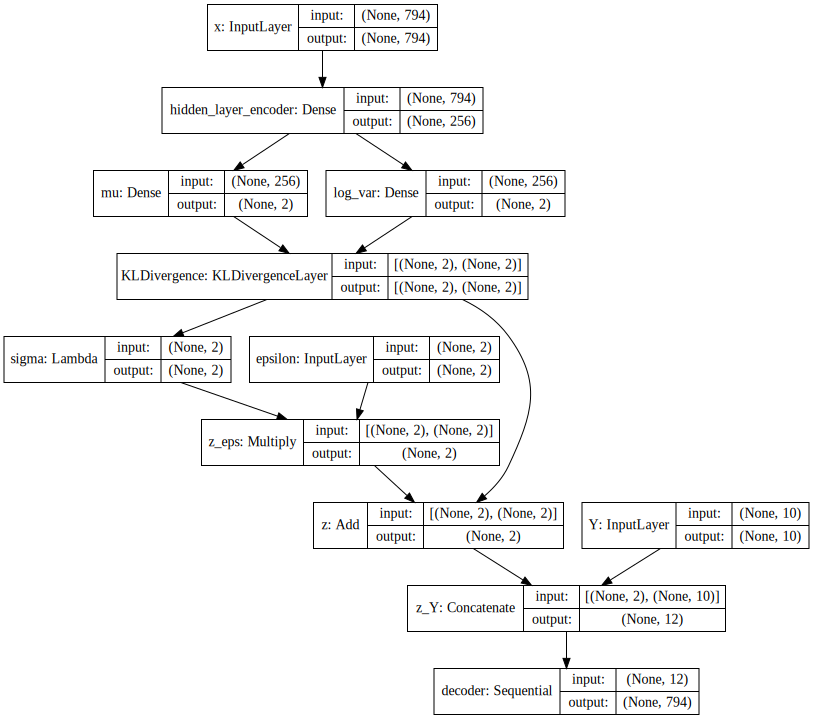

In [21]:
import pydotplus
import pydot
from keras.utils.vis_utils import model_to_dot
Keras.utils.vis_utils.pydot = pydot

SVG(model_to_dot(vae, show_shapes=True)
    .create(prog='dot', format='svg'))


##### Model fitting

In [22]:
#Data extraction
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim-10) / 255.
x_test = x_test.reshape(-1, original_dim-10) / 255.
#creating one-hot vector for each digit
Y_train=np.zeros((60000,10))

for i in range(60000):
    Y_train[i,y_train[i]]=1

Y_test=np.zeros((10000,10))
for i in range(10000):
    Y_test[i,y_test[i]]=1
#Concatinationg the pixels of the digit with Y the one-hot vector representing the Class of the digit 
x_train=np.concatenate((Y_train,x_train),axis=1)
x_test=np.concatenate((Y_test,x_test),axis=1)


In [23]:
#Training the VAE
hist = vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test,x_test)
)




Train on 60000 samples, validate on 10000 samples
Epoch 1/50





60000/60000 [==============================] - 8s 137us/step - loss: 176.4446 - val_loss: 151.4249
Epoch 2/50
60000/60000 [==============================] - 7s 123us/step - loss: 146.9201 - val_loss: 142.8676
Epoch 3/50
60000/60000 [==============================] - 7s 121us/step - loss: 141.6426 - val_loss: 140.0450
Epoch 4/50
60000/60000 [==============================] - 7s 122us/step - loss: 139.3527 - val_loss: 138.4635
Epoch 5/50
60000/60000 [==============================] - 7s 120us/step - loss: 137.9947 - val_loss: 137.2651
Epoch 6/50
60000/60000 [==============================] - 7s 112us/step - loss: 137.0491 - val_loss: 136.5799
Epoch 7/50
60000/60000 [==============================] - 7s 115us/step - loss: 136.3019 - val_loss: 136.4114
Epoch 8/50
60000/60000 [==============================] - 7s 114us/step - loss: 135.7103 - val_loss: 135.8490
Epoch 9/50
60000/60000 [==============================] - 7s 1

##### Model Evaluation

<IPython.core.display.Javascript object>


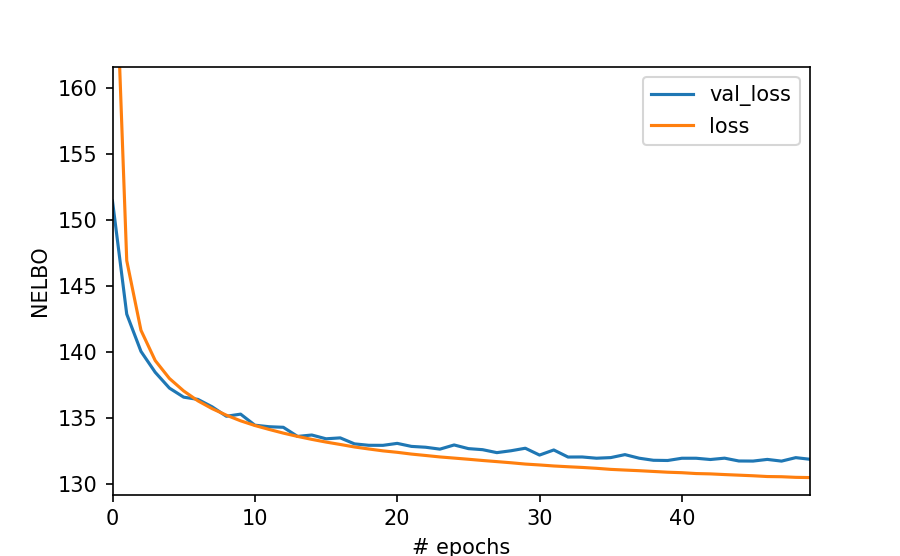

In [24]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))
#NELBO
fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())


plt.show()

##### Observing the Output 

In [26]:
# display a 2D manifold of the images
# a figure with 10x10 images
n = 10  
# Z ~ N(0,1)
quantile_min = 0.1
quantile_max = 0.99

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

# Z=[z1,z2]
z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n))
z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n))
#the one-hot vector 
# Y=[z3,z4,z5,z6,z8,z9,z10,z11,z12,z13]
z3=0  #0
z4=0  #1
z5=1  #2
z6=0  #3
z7=0  #4
z8=0  #5
z9=0  #6
z10=0 #7
z11=0 #8
z12=0 #9
# in this example Y=[0,0,1,0,0,0,0,0,0,0] so the class is 2
z_grid = np.dstack(np.meshgrid(z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12))
s=z_grid.reshape(n*n, 12)

In [27]:
x_pred_grid = decoder.predict(s) 
x_pred_grid=(x_pred_grid[:,10:794])\
                                  .reshape(n, n, img_rows, img_cols)

<IPython.core.display.Javascript object>


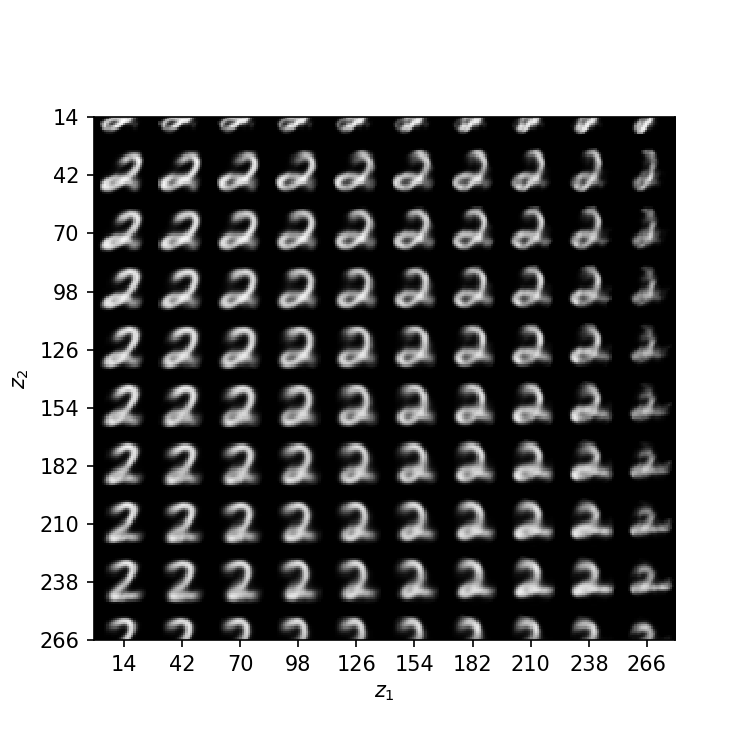

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')

ax.set_xticks(np.arange(0, n*img_rows, img_rows) + .5 * img_rows)


ax.set_yticks(np.arange(0, n*img_cols, img_cols) + .5 * img_cols)


ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

plt.show()